In [221]:
# Imported Libraries

# Core Libraries
import pandas as pd
import numpy as np
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling & Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Environment Settings
np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('ggplot')


In [222]:
# Loading the Datasets

# Real Estate Dataset
try:
    real_estate = pd.read_csv('realtor-data.zip.csv')
    print(f"Real estate data loaded. Shape: {real_estate.shape}")
except FileNotFoundError:
    print("Real estate data file not found. Please check 'realtor-data.zip.csv' is in directory.")
    raise

# Economic Indicator Dataset
try:
    economic_data = pd.read_csv('Annual_Macroeconomic_Factors.csv')
    print(f"Economic data loaded. Shape: {economic_data.shape}")
except FileNotFoundError:
    print("Economic data file not found. Please check 'Annual_Macroeconomic_Factors.csv' is in directory.")
    raise

# Convert to datetime format
real_estate['prev_sold_date'] = pd.to_datetime(real_estate['prev_sold_date'], errors='coerce')
economic_data['Date'] = pd.to_datetime(economic_data['Date'], errors='coerce')
# Extract year from both datasets 
real_estate['year'] = real_estate['prev_sold_date'].dt.year
economic_data['year'] = economic_data['Date'].dt.year
# Display Both Datasets
print("\nReal Estate Data Sample:")
display(real_estate.head())
print("\nEconomic Data Sample:")
display(economic_data.head())


Real estate data loaded. Shape: (2226382, 12)
Economic data loaded. Shape: (47, 9)

Real Estate Data Sample:


,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date,year
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaT,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaT,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaT,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaT,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaT,NaN



Economic Data Sample:


,Date,House_Price_Index,Stock_Price_Index,Consumer_Price_Index,Population,Unemployment_Rate,Real_GDP,Mortgage_Rate,Real_Disposable_Income,year
0,1975-01-01,61.0900,67.14653,65.30488,0.98599,8.46667,5648.462,9.04712,19908.0,1975
1,1976-01-01,65.5250,79.96264,69.05653,0.95022,7.71667,5952.809,8.86585,20346.0,1976
2,1977-01-01,73.4350,78.82540,73.54636,1.00577,7.06667,6228.076,8.84519,20780.0,1977
3,1978-01-01,83.7450,78.84679,79.15866,1.05957,6.06667,6572.819,9.64173,21497.0,1978
4,1979-01-01,95.1325,85.63207,88.06755,1.10358,5.83333,6780.924,11.20365,21672.0,1979


In [224]:
# Clean Real Estate Data
def clean_real_estate_data(df):
    df = df.copy()
# Only use US States and drop US territories
    us_states_full = [
        'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut',
        'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
        'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
        'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
        'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
        'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
        'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'
    ]

    df['state_cleaned'] = df['state'].str.title()
    df = df[df['state_cleaned'].isin(us_states_full)]
# Drop any empty values in date column 
    df['prev_sold_date'] = pd.to_datetime(df['prev_sold_date'], errors='coerce')
    df = df.dropna(subset=['prev_sold_date'])
    df['year'] = df['prev_sold_date'].dt.year
# Only keep information about housing prices from 1995 to 2021
    df = df[(df['year'] >= 1995) & (df['year'] <= 2021)]
# Drop any irrelevant columns 
    keep_columns = [
        'price', 'bed', 'bath', 'acre_lot', 'house_size', 'state',
        'zip_code', 'prev_sold_date', 'year'
    ]
    df = df[[col for col in keep_columns if col in df.columns]]

    critical_features = ['price', 'bed', 'bath', 'house_size', 'state']
    df = df.dropna(subset=critical_features)
    df = df.dropna(subset=['acre_lot'])
# Filter unrealistic data 
    df = df[
        (df['price'].between(100_000, 500_000)) & # range kept based on historical data of median house prices 
        (df['bed'].between(1, 15)) &
        (df['bath'].between(1, 10)) &
        (df['house_size'] > 100)
    ]

# Drop any duplicates
    df = df.drop_duplicates(
        subset=['price', 'bed', 'bath', 'house_size', 'zip_code', 'prev_sold_date']
    )
    df = df.reset_index(drop=True)
    return df
# Perform Cleaning function
real_estate_clean = clean_real_estate_data(real_estate)
# Save as New CSV
real_estate_clean.to_csv('cleaned_real_estate_data.csv', index=False)
real_estate_clean.head()


,price,bed,bath,acre_lot,house_size,state,zip_code,prev_sold_date,year
0,289900.0,3.0,2.0,0.36,1276.0,Massachusetts,1001.0,2012-10-12,2012
1,199999.0,3.0,2.0,1.76,1968.0,Massachusetts,1001.0,2008-09-19,2008
2,419000.0,4.0,2.0,2.00,1607.0,Massachusetts,1002.0,2005-07-25,2005
3,275000.0,3.0,2.0,0.16,1280.0,Massachusetts,1002.0,2021-08-19,2021
4,415000.0,4.0,2.0,0.49,1814.0,Massachusetts,1002.0,1997-06-30,1997


In [225]:
def clean_economic_data(df):
    df = df.copy()
# Convert to datetime format
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['year'] = df['Date'].dt.year
# Keep relevant columns
    keep_columns = ['Mortgage_Rate', 'Unemployment_Rate', 'Real_GDP', 'Real_Disposable_Income', 'Consumer_Price_Index', 'year']
    df = df[[col for col in keep_columns if col in df.columns]]
    df = df.dropna(subset=['year', 'Mortgage_Rate', 'Unemployment_Rate', 'Real_GDP', 'Real_Disposable_Income', 'Consumer_Price_Index'])
    df['year'] = df['year'].astype(int)
# Only keep data from 1995 to 2021
    df = df[(df['year'] >= 1995) & (df['year'] <= 2021)]
    df = df.drop_duplicates(subset=['year'])
    df = df.reset_index(drop=True)

    return df
# Perform cleaning function
economic_clean = clean_economic_data(economic_data)
# Save as New CSV
economic_clean.to_csv('cleaned_economic_data.csv', index=False)
economic_clean.head()


,Mortgage_Rate,Unemployment_Rate,Real_GDP,Real_Disposable_Income,Consumer_Price_Index,year
0,7.93462,5.60833,10636.979,29011.0,184.91253,1995
1,7.80615,5.41667,11038.266,29586.0,190.33269,1996
2,7.59885,4.95000,11529.157,30304.0,194.78208,1997
3,6.94264,4.50833,12045.824,31712.0,197.80564,1998
4,7.44000,4.21667,12623.361,32409.0,202.13368,1999


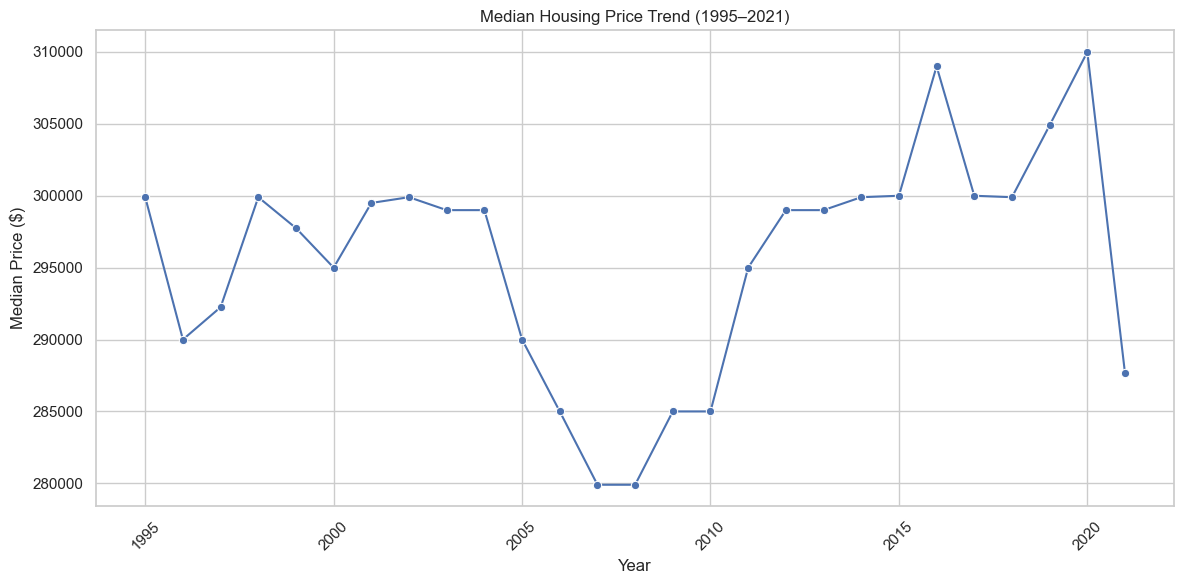

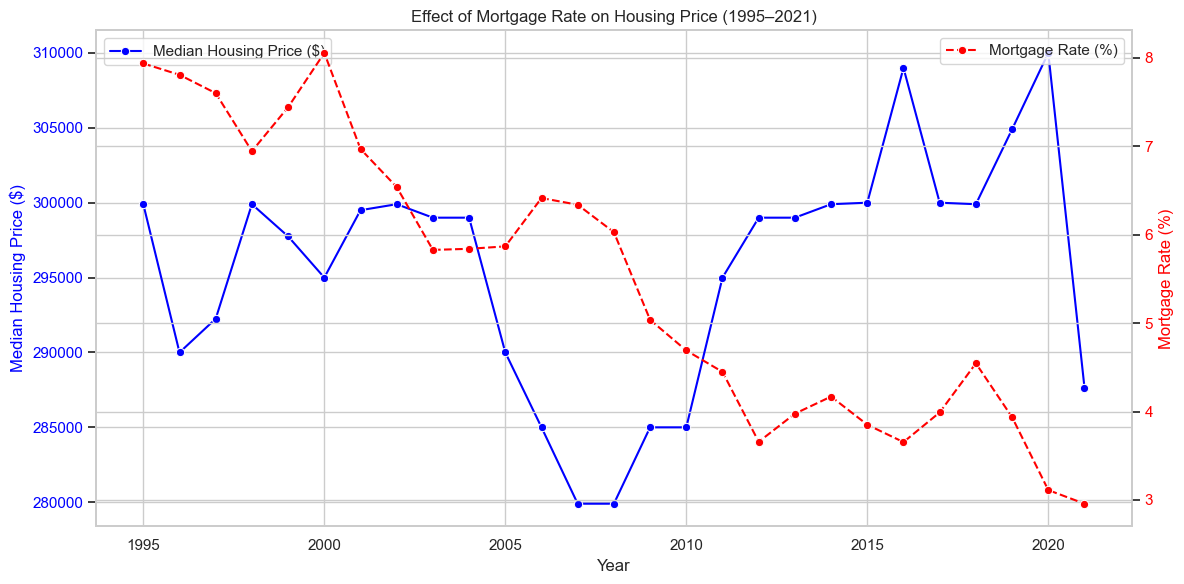

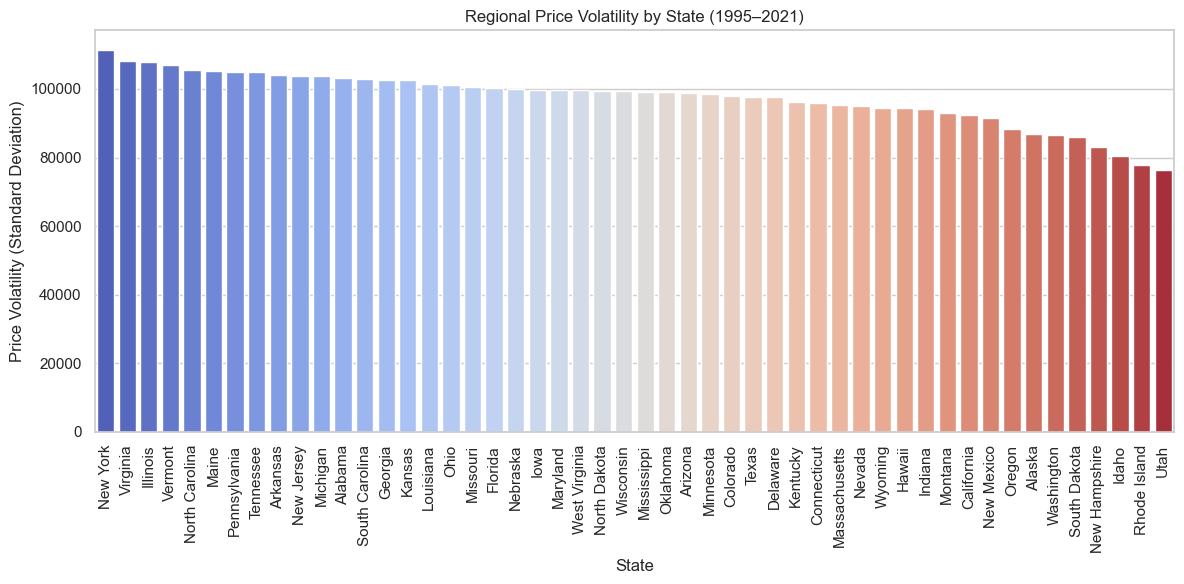

In [233]:
# Exploratory Data Analysis

# 1. Median Housing Price Trend
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
price_trend = real_estate_clean.groupby('year')['price'].median().reset_index()
sns.lineplot(
    data=price_trend,
    x='year', y='price', marker='o', errorbar='sd')
plt.title('Median Housing Price Trend (1995–2021)')
plt.xlabel('Year')
plt.ylabel('Median Price ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 2. Effect of Mortgage Rate on Housing Price
price_trend = real_estate_clean.groupby('year')['price'].median().reset_index()
mortgage_rate_trend = economic_clean[['year', 'Mortgage_Rate']]
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_xlabel('Year')
ax1.set_ylabel('Median Housing Price ($)', color='blue')
sns.lineplot(data=price_trend, x='year', y='price', ax=ax1, label='Median Housing Price ($)', color='blue', marker='o')
ax2 = ax1.twinx()
ax2.set_ylabel('Mortgage Rate (%)', color='red')
sns.lineplot(data=mortgage_rate_trend, x='year', y='Mortgage_Rate', ax=ax2, label='Mortgage Rate (%)', color='red', marker='o', linestyle='--')
plt.title('Effect of Mortgage Rate on Housing Price (1995–2021)')
ax1.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='red')
plt.tight_layout()
plt.show()

# 3. Regional Price Volatility by State
price_mean = real_estate_clean['price'].mean()
price_std = real_estate_clean['price'].std()
price_threshold_upper = price_mean + 3 * price_std
price_threshold_lower = price_mean - 3 * price_std
filtered_real_estate = real_estate_clean[(real_estate_clean['price'] <= price_threshold_upper) & (real_estate_clean['price'] >= price_threshold_lower)]
price_volatility_by_state = filtered_real_estate.groupby('state')['price'].std().reset_index()
price_volatility_by_state = price_volatility_by_state.sort_values('price', ascending=False)
price_volatility_by_state_year = filtered_real_estate.groupby(['state', 'year'])['price'].std().reset_index()
price_volatility_avg = price_volatility_by_state_year.groupby('state')['price'].mean().reset_index()
price_volatility_avg = price_volatility_avg.sort_values('price', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=price_volatility_avg, x='state', y='price', hue='state', palette='coolwarm', legend=False)
plt.title( 'Regional Price Volatility by State (1995–2021)')
plt.xlabel('State')
plt.ylabel('Price Volatility (Standard Deviation)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()




                       year     price  Mortgage_Rate  Unemployment_Rate  Real_GDP
year               1.000000 -0.002268      -0.955274          -0.072388  0.991341
price             -0.002268  1.000000       0.003297          -0.003031 -0.005513
Mortgage_Rate     -0.955274  0.003297       1.000000          -0.119286 -0.926572
Unemployment_Rate -0.072388 -0.003031      -0.119286           1.000000 -0.166499
Real_GDP           0.991341 -0.005513      -0.926572          -0.166499  1.000000


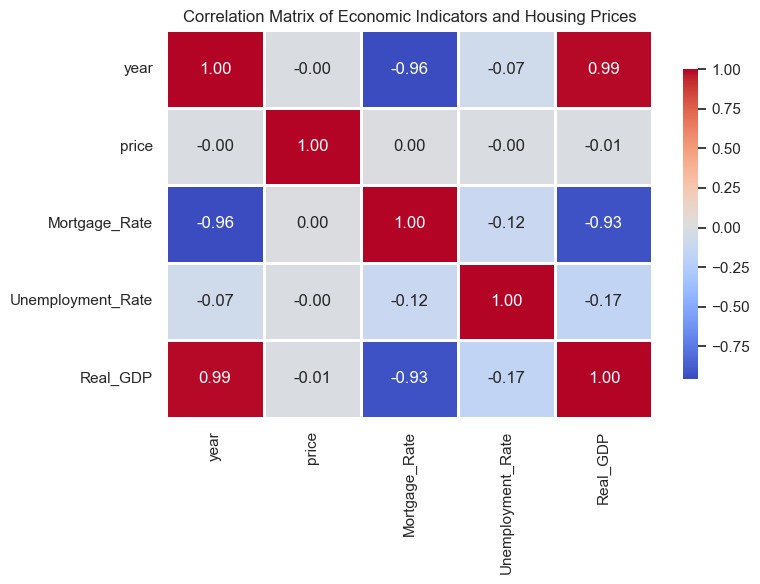

In [227]:
# Correlation Analysis
# Merge on year
merged_data = pd.merge(real_estate_clean[['year', 'price']], economic_clean[['year', 'Mortgage_Rate', 'Unemployment_Rate', 'Real_GDP']], on='year')
correlation_matrix = merged_data.corr()
print(correlation_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1, cbar_kws={'shrink': .8})
plt.title('Correlation Matrix of Economic Indicators and Housing Prices')
plt.tight_layout()
plt.show()


Random Forest - MAE: 91600.21003058556 RMSE: 107701.26789770402
XGBoost - MAE: 91602.98057202404 RMSE: 107702.43289383079


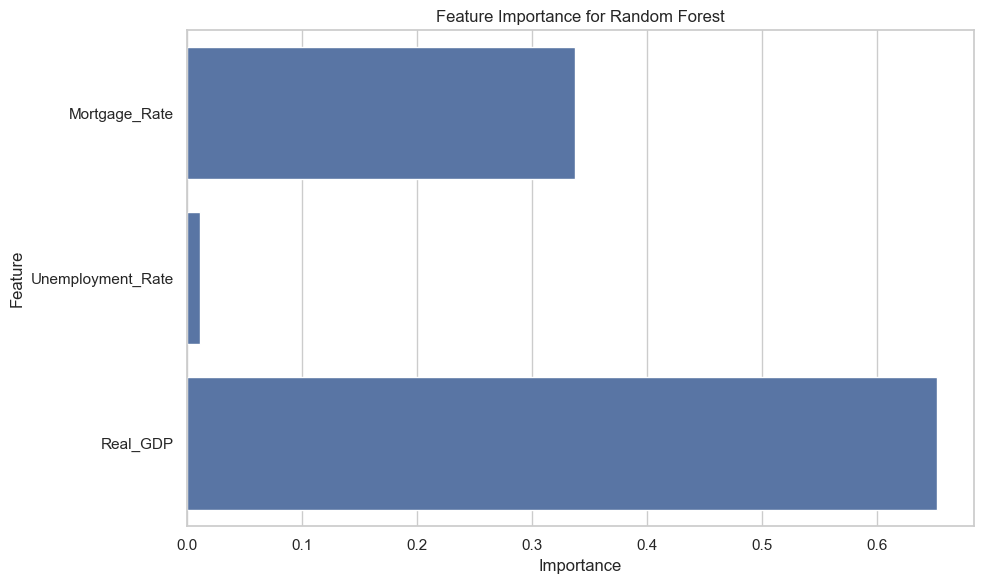

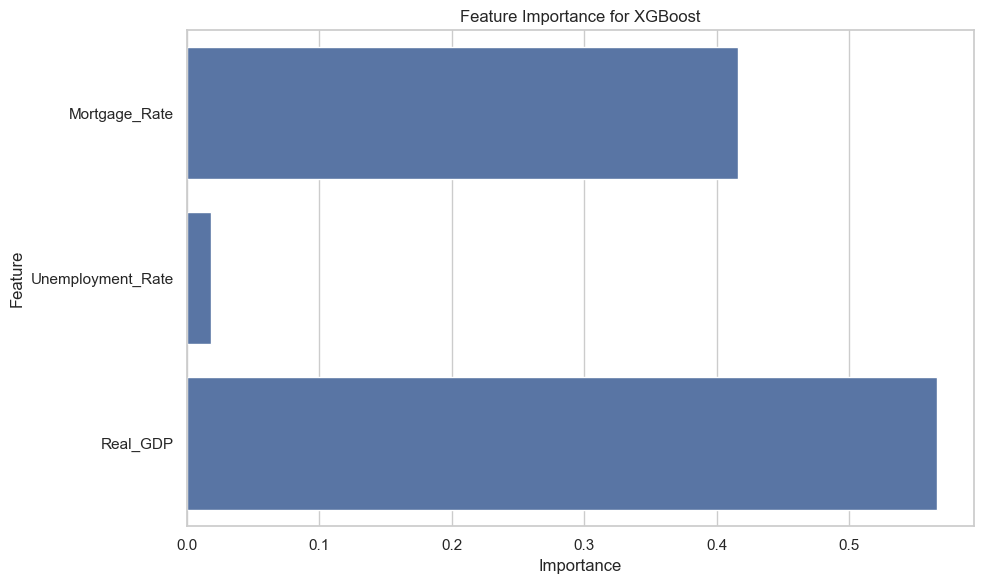

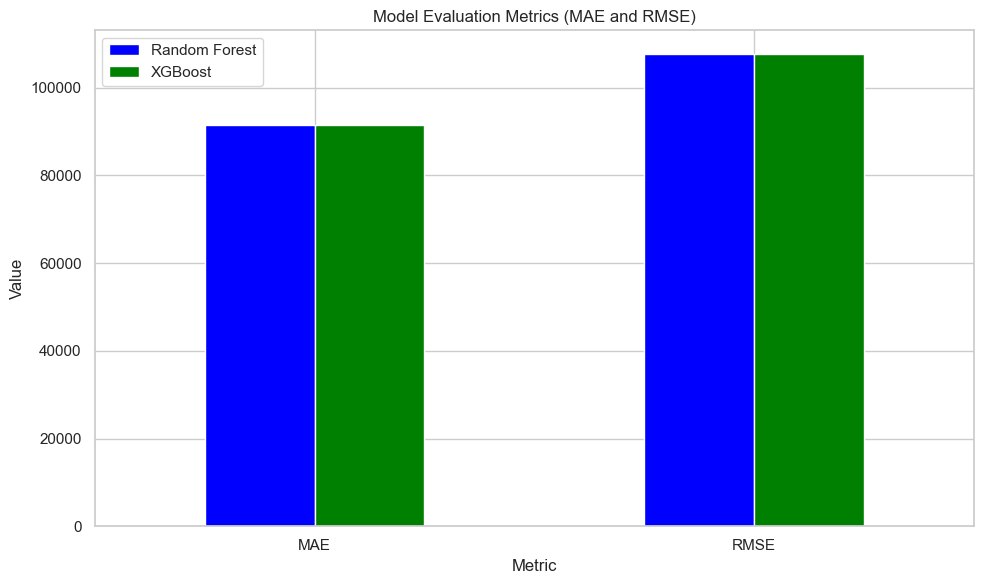

In [228]:
# Predictive Modeling

# Random Forest and XGBoost 
X = merged_data[['Mortgage_Rate', 'Unemployment_Rate', 'Real_GDP']]
y = merged_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}
xgb_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
rf_grid_search.fit(X_train, y_train)
xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
xgb_grid_search.fit(X_train, y_train)

best_rf_model = rf_grid_search.best_estimator_
best_xgb_model = xgb_grid_search.best_estimator_

y_pred_rf = best_rf_model.predict(X_test)
y_pred_xgb = best_xgb_model.predict(X_test)

# Model Evaluation 

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

mae_rf, rmse_rf = evaluate_model(y_test, y_pred_rf)
mae_xgb, rmse_xgb = evaluate_model(y_test, y_pred_xgb)

print("Random Forest - MAE:", mae_rf, "RMSE:", rmse_rf)
print("XGBoost - MAE:", mae_xgb, "RMSE:", rmse_xgb)

importances_rf = best_rf_model.feature_importances_
importances_xgb = best_xgb_model.feature_importances_

plt.figure(figsize=(10, 6))
sns.barplot(x=importances_rf, y=X.columns)
plt.title('Feature Importance for Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=importances_xgb, y=X.columns)
plt.title('Feature Importance for XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

metrics = {
    'Random Forest': [mae_rf, rmse_rf],
    'XGBoost': [mae_xgb, rmse_xgb]
}

metrics_df = pd.DataFrame(metrics, index=['MAE', 'RMSE'])

# Plotting the metrics MAE and RMSE
metrics_df.plot(kind='bar', figsize=(10, 6), color=['blue', 'green'])
plt.title('Model Evaluation Metrics (MAE and RMSE)')
plt.ylabel('Value')
plt.xlabel('Metric')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
